2a. The authors have chosen network depth as 25 because:
1. Choosing a higher value might degrade the training accuracy
2. Helps to analyze the effective path size of denoising methods which directly correlates with the receptive field size of denoising neural networks

DnCNN 3 is designed to solve three general image denoising tasks which are:
1. Blind Gaussian denoising
2. SISR with multiple upscaling factors
3. JPEG deblocking with different quality factors

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


2b. Using main_test.py to test the pretrained model on denoising the whole Set68 with σ=25 and σ=36

In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/data/Test', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/models/model_000.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    #show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

2019-11-23 16:44:39: load trained model
     Set68 : test001.png : 0.0564 second
     Set68 : test002.png : 0.0294 second
     Set68 : test003.png : 0.0293 second
     Set68 : test004.png : 0.0292 second
     Set68 : test006.png : 0.0292 second
     Set68 : test007.png : 0.0293 second
     Set68 : test013.png : 0.0294 second
     Set68 : test005.png : 0.0292 second
     Set68 : test014.png : 0.0293 second
     Set68 : test010.png : 0.0291 second
     Set68 : test009.png : 0.0292 second
     Set68 : test011.png : 0.0293 second
     Set68 : test008.png : 0.0293 second
     Set68 : test012.png : 0.0292 second
     Set68 : test015.png : 0.0293 second
     Set68 : test016.png : 0.0294 second
     Set68 : test018.png : 0.0292 second
     Set68 : test017.png : 0.0293 second
     Set68 : test019.png : 0.0292 second
     Set68 : test020.png : 0.0292 second
     Set68 : test021.png : 0.0293 second
     Set68 : test027.png : 0.0292 second
     Set68 : test028.png : 0.0293 second
     Set68 : test

With σ=25, PSNR = 29.26dB and SSIM = 0.9022

In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/data/Test', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    parser.add_argument('--sigma', default=36, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/models/model_000.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    #show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

2019-11-23 16:46:46: load trained model
     Set68 : test001.png : 0.0293 second
     Set68 : test002.png : 0.0291 second
     Set68 : test003.png : 0.0293 second
     Set68 : test004.png : 0.0293 second
     Set68 : test006.png : 0.0287 second
     Set68 : test007.png : 0.0274 second
     Set68 : test013.png : 0.0273 second
     Set68 : test005.png : 0.0273 second
     Set68 : test014.png : 0.0274 second
     Set68 : test010.png : 0.0272 second
     Set68 : test009.png : 0.0273 second
     Set68 : test011.png : 0.0278 second
     Set68 : test008.png : 0.0273 second
     Set68 : test012.png : 0.0273 second
     Set68 : test015.png : 0.0273 second
     Set68 : test016.png : 0.0275 second
     Set68 : test018.png : 0.0273 second
     Set68 : test017.png : 0.0273 second
     Set68 : test019.png : 0.0272 second
     Set68 : test020.png : 0.0273 second
     Set68 : test021.png : 0.0274 second
     Set68 : test027.png : 0.0272 second
     Set68 : test028.png : 0.0274 second
     Set68 : test

With σ=36, PSNR = 22.05dB and SSIM = 0.5912

2c. Pre-training model using script main_train.py for 1 epoch with learning rate
0.0001 with σ = 36 and testing its performance (PSRN/SSIM) on Set68

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Assignment B/DnCNN/DnCNN')

In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to train the model
import argparse
import re
import os, glob, datetime, time
import numpy as np
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import data_generator as dg
from data_generator import DenoisingDataset


# Params
parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--batch_size', default=128, type=int, help='batch size')
parser.add_argument('--train_data', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/data/Train400', type=str, help='path of train data')
parser.add_argument('--sigma', default=36, type=int, help='noise level')
parser.add_argument('--epochs', default=1, type=int, help='number of train epochs')
parser.add_argument('--lr', default=0.0001, type=float, help='initial learning rate for Adam')
args = parser.parse_args(args=[])

batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epochs = args.epochs
sigma = args.sigma

save_dir = '/content/drive/My Drive/Assignment B/DnCNN/DnCNN/file_new'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)


class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


class sum_squared_error(_Loss):
    """
    Definition: sum_squared_error = 1/2 * nn.MSELoss(reduction = 'sum')
    The backward is defined as: input-target
    """
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)


def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).pth.*", file_)
            epochs_exist.append(int(result[0]))
        initial_epoch = max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


if __name__ == '__main__':
    # model selection
    print('===> Building model')
    model = DnCNN()
    
    initial_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
    if initial_epoch > 0 or os.path.isfile(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch)):
        print('resuming by loading epoch %03d' % initial_epoch)
        model = torch.load(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch))
    model.train()
    criterion = sum_squared_error()
    if cuda:
        model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = MultiStepLR(optimizer, milestones=[15], gamma=0.1)  # learning rates
    for epoch in range(initial_epoch, n_epochs):

        scheduler.step(epoch)  # step to the learning rate in this epcoh
        xs = dg.datagenerator(data_dir=args.train_data)
        xs = xs.astype('float32')/255.0
        xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
        DDataset = DenoisingDataset(xs, sigma)
        DLoader = DataLoader(dataset=DDataset, num_workers=0, drop_last=True, batch_size=batch_size, shuffle=True)
        epoch_loss = 0
        start_time = time.time()

        for n_count, batch_yx in enumerate(DLoader):
            optimizer.zero_grad()
            if cuda:
                batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()
            else:
                batch_x, batch_y = batch_yx[1], batch_yx[0]
            loss = criterion(model(batch_y), batch_x)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            if n_count % 100 == 0:
                print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, xs.size(0)//batch_size, loss.item()/batch_size))
        elapsed_time = time.time() - start_time

        log('epcoh = %4d , loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, elapsed_time))
        np.savetxt('/content/drive/My Drive/Assignment B/DnCNN/DnCNN/train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
        torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))



===> Building model
resuming by loading epoch 001


2019-11-23 16:51:45: load trained model
     Set68 : test001.png : 0.0296 second


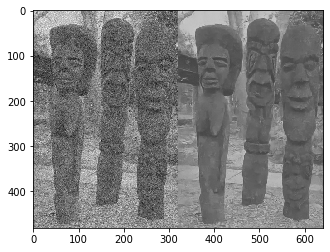

     Set68 : test002.png : 0.0292 second


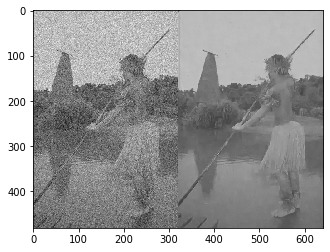

     Set68 : test003.png : 0.0293 second


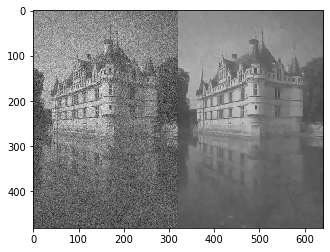

     Set68 : test004.png : 0.0291 second


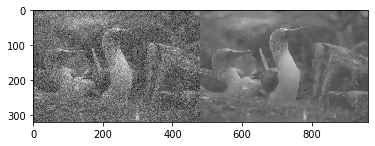

     Set68 : test006.png : 0.0293 second


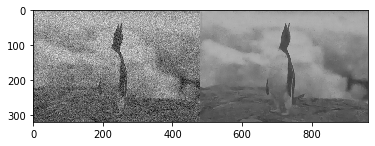

     Set68 : test007.png : 0.0291 second


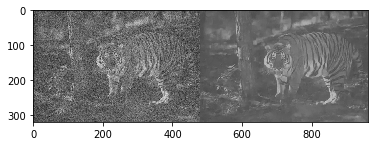

     Set68 : test013.png : 0.0292 second


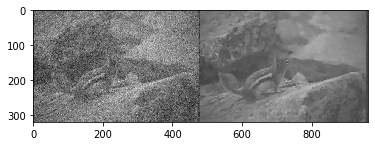

     Set68 : test005.png : 0.0291 second


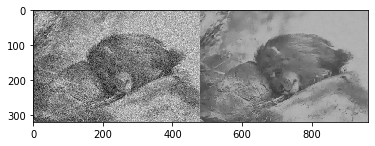

     Set68 : test014.png : 0.0291 second


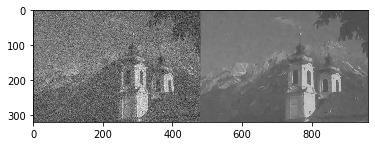

     Set68 : test010.png : 0.0291 second


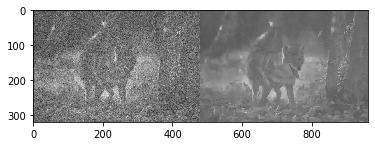

     Set68 : test009.png : 0.0291 second


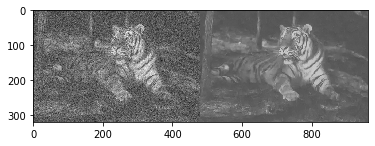

     Set68 : test011.png : 0.0291 second


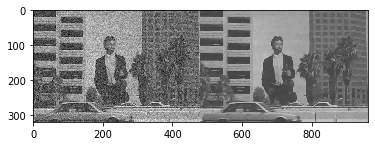

     Set68 : test008.png : 0.0292 second


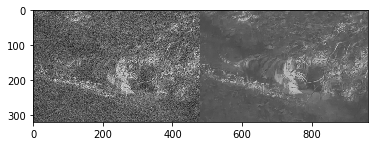

     Set68 : test012.png : 0.0292 second


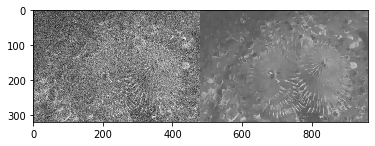

     Set68 : test015.png : 0.0291 second


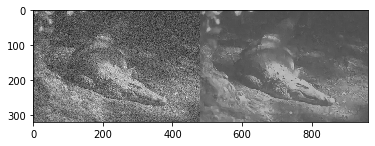

     Set68 : test016.png : 0.0292 second


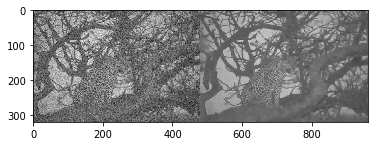

     Set68 : test018.png : 0.0291 second


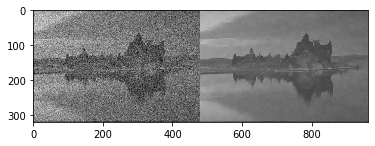

     Set68 : test017.png : 0.0291 second


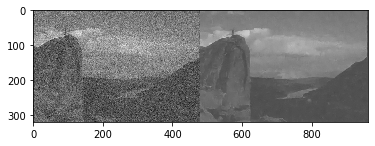

     Set68 : test019.png : 0.0292 second


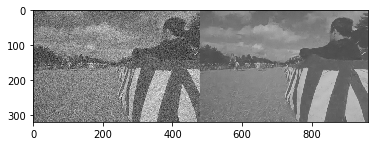

     Set68 : test020.png : 0.0292 second


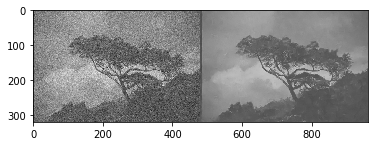

     Set68 : test021.png : 0.0292 second


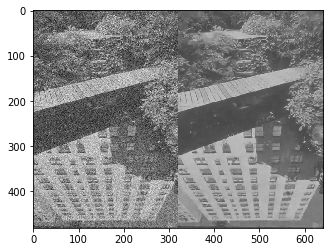

     Set68 : test027.png : 0.0291 second


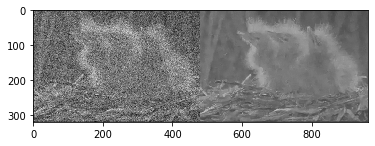

     Set68 : test028.png : 0.0291 second


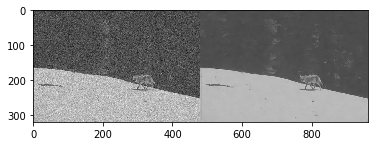

     Set68 : test024.png : 0.0292 second


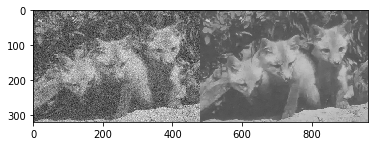

     Set68 : test023.png : 0.0291 second


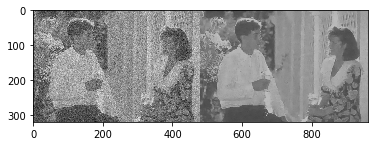

     Set68 : test022.png : 0.0291 second


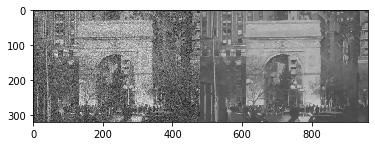

     Set68 : test030.png : 0.0291 second


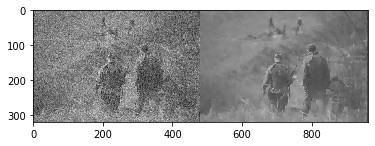

     Set68 : test029.png : 0.0294 second


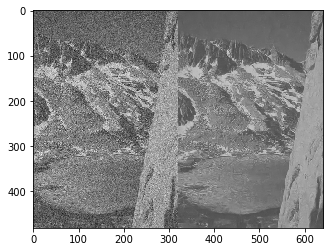

     Set68 : test031.png : 0.0293 second


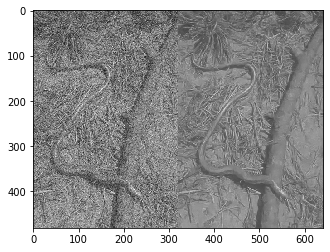

     Set68 : test025.png : 0.0292 second


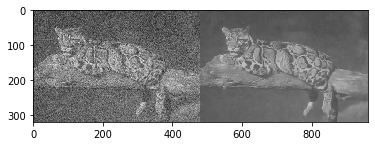

     Set68 : test026.png : 0.0292 second


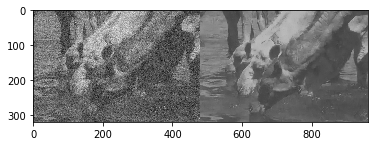

     Set68 : test032.png : 0.0292 second


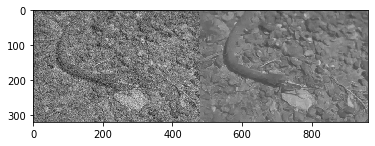

     Set68 : test033.png : 0.0293 second


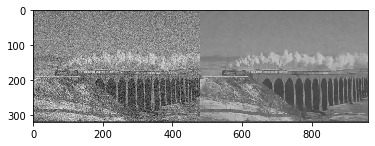

     Set68 : test035.png : 0.0291 second


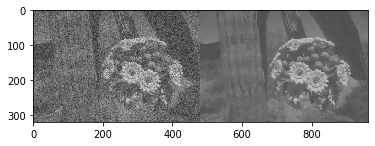

     Set68 : test036.png : 0.0292 second


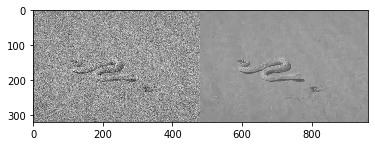

     Set68 : test034.png : 0.0292 second


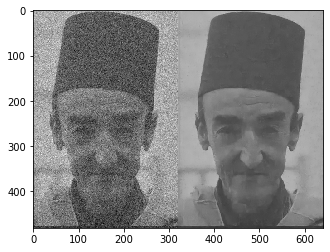

     Set68 : test042.png : 0.0293 second


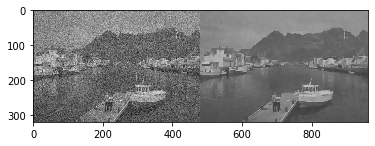

     Set68 : test043.png : 0.0291 second


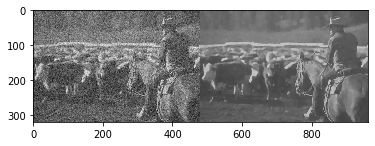

     Set68 : test037.png : 0.0291 second


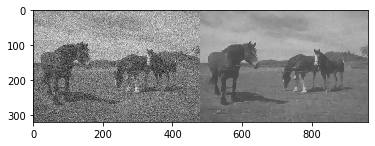

     Set68 : test040.png : 0.0291 second


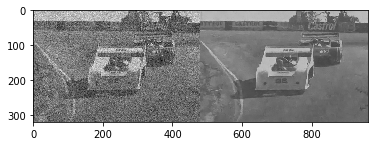

     Set68 : test039.png : 0.0292 second


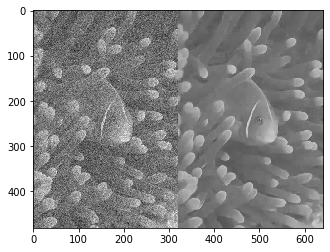

     Set68 : test041.png : 0.0292 second


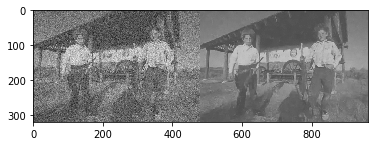

     Set68 : test038.png : 0.0292 second


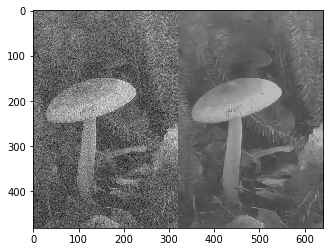

     Set68 : test044.png : 0.0291 second


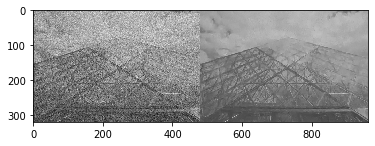

     Set68 : test046.png : 0.0291 second


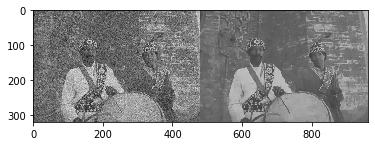

     Set68 : test047.png : 0.0291 second


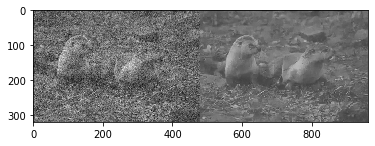

     Set68 : test048.png : 0.0290 second


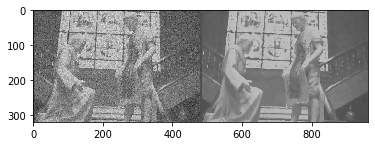

     Set68 : test054.png : 0.0292 second


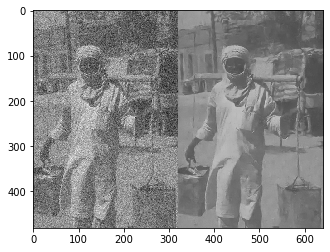

     Set68 : test055.png : 0.0294 second


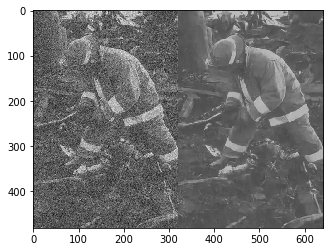

     Set68 : test049.png : 0.0294 second


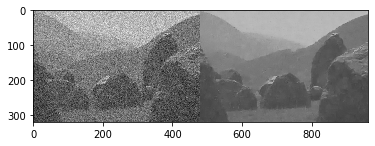

     Set68 : test051.png : 0.0292 second


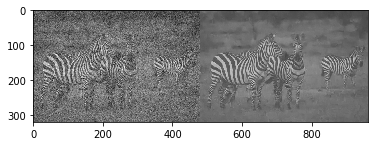

     Set68 : test050.png : 0.0292 second


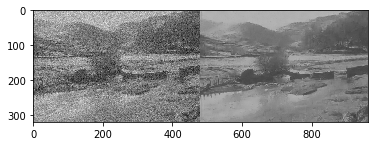

     Set68 : test045.png : 0.0293 second


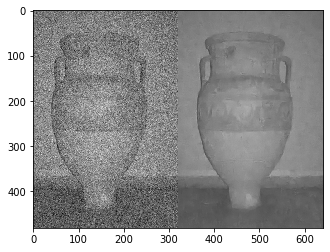

     Set68 : test056.png : 0.0291 second


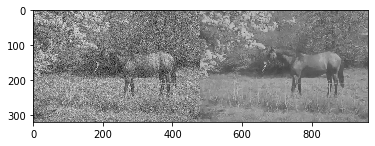

     Set68 : test057.png : 0.0291 second


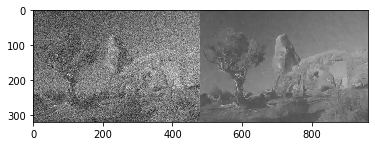

     Set68 : test058.png : 0.0293 second


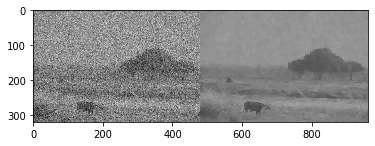

     Set68 : test052.png : 0.0291 second


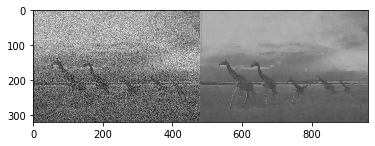

     Set68 : test053.png : 0.0291 second


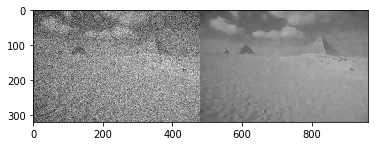

     Set68 : test060.png : 0.0291 second


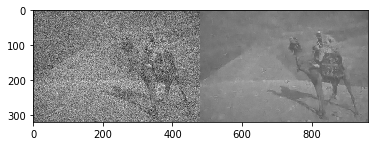

     Set68 : test061.png : 0.0291 second


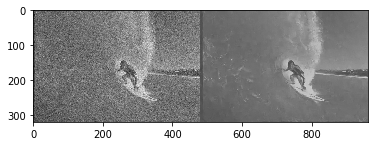

     Set68 : test059.png : 0.0292 second


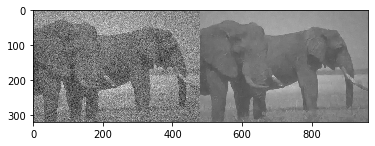

     Set68 : test062.png : 0.0293 second


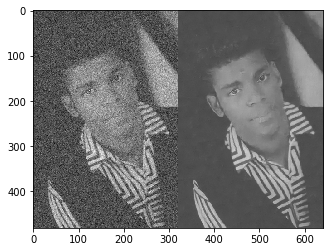

     Set68 : test063.png : 0.0293 second


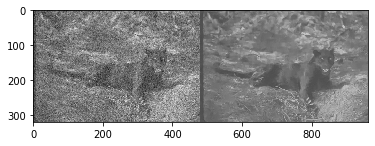

     Set68 : test064.png : 0.0293 second


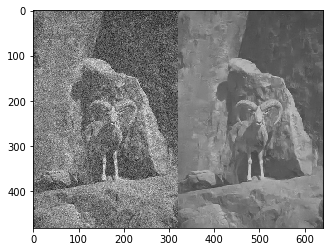

     Set68 : test065.png : 0.0291 second


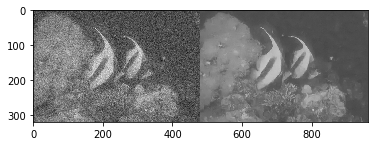

     Set68 : test068.png : 0.0291 second


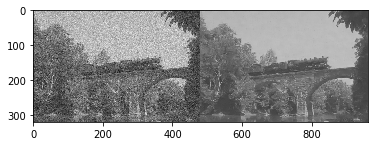

     Set68 : test067.png : 0.0293 second


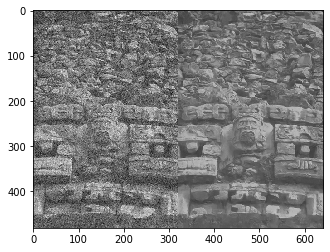

     Set68 : test066.png : 0.0293 second


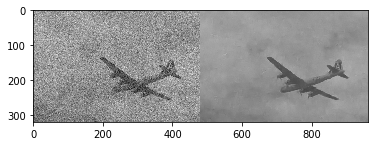

2019-11-23 16:52:04: Datset: Set68      
  PSNR = 26.87dB, SSIM = 0.8424


In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/data/Test', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    #parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--sigma', default=36, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/file_new/model_001.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                args.save_result = 'true'
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



PSNR = 26.87dB, SSIM = 0.8424

2d. Using pre-trained and finetuned models to denoise allotted image and computing their performance.

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:459: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/u

2019-11-23 16:56:23: load trained model
     Set68 : CHAKRASA@TCD.IE_019.png : 0.0297 second


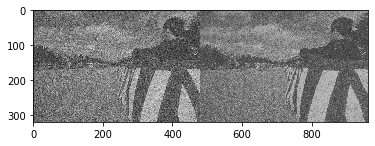

2019-11-23 16:56:24: Datset: Set68      
  PSNR = 19.19dB, SSIM = 0.7481


In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/Image_2nd', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    #parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--sigma', default=36, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/models/model_000.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                args.save_result = 'true'
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



With pre-trained model: PSNR = 19.19dB, SSIM = 0.7481

2019-11-23 16:57:32: load trained model
     Set68 : CHAKRASA@TCD.IE_019.png : 0.0290 second


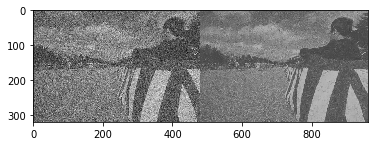

2019-11-23 16:57:32: Datset: Set68      
  PSNR = 19.16dB, SSIM = 0.6385


In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/Image_2nd', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    #parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--sigma', default=36, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/file_new/model_001.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)
                args.save_result = 'true'
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    show(np.hstack((y, x_)))  # show the image
                    save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, 'results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



With finetuned model: PSNR = 19.16dB, SSIM = 0.6385

2e. i. Generating noise from CHAKRASA@TCD.IE_019.png by finetuned network and saving it as a grayscale image centered around intensity 127.

ii. Computing Standard Deviation of noise in the image.

2019-11-23 17:13:25: load trained model
     Set68 : CHAKRASA@TCD.IE_019.png : 0.0291 second


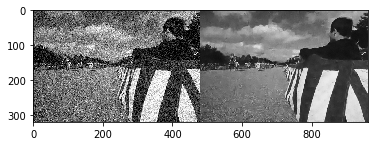

2019-11-23 17:13:25: Datset: Set68      
  PSNR = 17.88dB, SSIM = 0.3827


In [0]:
# -*- coding: utf-8 -*-

# =============================================================================
#  @article{zhang2017beyond,
#    title={Beyond a {Gaussian} denoiser: Residual learning of deep {CNN} for image denoising},
#    author={Zhang, Kai and Zuo, Wangmeng and Chen, Yunjin and Meng, Deyu and Zhang, Lei},
#    journal={IEEE Transactions on Image Processing},
#    year={2017},
#    volume={26}, 
#    number={7}, 
#    pages={3142-3155}, 
#  }
# modified version of the code from https://github.com/cszn/DnCNN
# =============================================================================

# run this to test the model

import argparse
import os, time, datetime
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch
from skimage.measure import compare_psnr, compare_ssim
from skimage.io import imread, imsave
import matplotlib.pyplot as plt


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--set_dir', default='/content/drive/My Drive/Assignment B/Image_2nd', type=str, help='directory of test dataset')
    parser.add_argument('--set_names', default=['Set68'], help='directory of test dataset')
    #parser.add_argument('--sigma', default=25, type=int, help='noise level')
    parser.add_argument('--sigma', default=36, type=int, help='noise level')
    parser.add_argument('--model_path', default='/content/drive/My Drive/Assignment B/DnCNN/DnCNN/file_new/model_001.pth', type=str, help='the model name')
    parser.add_argument('--result_dir', default='results', type=str, help='directory of test dataset')
    parser.add_argument('--save_result', action='store_true', help='save the denoised image')
    return parser.parse_args(args=[])


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)


def save_result(result, path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.uint8(np.clip(result*255.0, 0, 255)))


def show(x, title=None, cbar=False, figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x, interpolation='nearest', cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()


class DnCNN(nn.Module):

    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


if __name__ == '__main__':

    args = parse_args()

    model = torch.load(args.model_path)
    log('load trained model')

    model.eval()  # evaluation mode

    if torch.cuda.is_available():
        model = model.cuda()

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir, set_cur)):
            os.mkdir(os.path.join(args.result_dir, set_cur))
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir, set_cur)):
            if im.endswith(".jpg") or im.endswith(".bmp") or im.endswith(".png"):

                x = np.array(imread(os.path.join(args.set_dir, set_cur, im)), dtype=np.float32)/255.0
                np.random.seed(seed=0)  # for reproducibility
                #y = x + np.random.normal(0, args.sigma/255.0, x.shape)  # Add Gaussian noise without clipping
                y=x
                y = y.astype(np.float32)
                y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

                torch.cuda.synchronize()
                start_time = time.time()
                y_ = y_.cuda()
                x_ = model(y_)  # inference
                x_ = x_.view(y.shape[0], y.shape[1])
                x_ = x_.cpu()
                x_ = x_.detach().numpy().astype(np.float32)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                print('%10s : %10s : %2.4f second' % (set_cur, im, elapsed_time))

                psnr_x_ = compare_psnr(x, x_)
                ssim_x_ = compare_ssim(x, x_)

                resi_img = x - x_
                y_temp = x_ + resi_img

                args.save_result = 'true'
                if args.save_result:
                    name, ext = os.path.splitext(im)
                    show(np.hstack((y, x_)))  # show the image
                    #save_result(x_, path=os.path.join(args.result_dir, set_cur, name+'_dncnn'+ext))  # save the denoised image
                    plt.imsave(os.path.join(args.result_dir, set_cur, name+'_noise'+ext), np.uint8(np.clip(resi_img*255.0, 0, 255.0)), cmap = 'gray', vmin=0, vmax=127)
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)
        if args.save_result:
            save_result(np.hstack((psnrs, ssims)), path=os.path.join(args.result_dir, set_cur, '/content/drive/My Drive/Assignment B/DnCNN/DnCNN/results.txt'))
        log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format(set_cur, psnr_avg, ssim_avg))



PSNR = 17.88dB, SSIM = 0.3827

In [0]:
#Computing the standard deviation
standard_deviation = np.std(resi_img)
print('Standard Deviation of noise =', standard_deviation)

Standard Deviation of noise = 0.12761873


REFERENCES:
1. Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising (https://arxiv.org/abs/1608.03981)
2. https://stackoverflow.com/questions/32294261/what-is-depth-of-a-convolutional-neural-network
3. http://www.vision.ee.ethz.ch/~timofter/publications/Gu-Chapter-2019.pdf